In [20]:
import pydotplus
import dtreeviz.trees
import rfpimp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from IPython.display import Image
from io import StringIO
from sklearn.experimental import enable_iterative_imputer
from sklearn import ensemble, impute, model_selection, preprocessing, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.features import FeatureImportances
from catboost import CatBoostClassifier
from tpot import TPOTClassifier

In [2]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [3]:
df = pd.read_csv('titanic3.csv')

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [4]:
# Logistic Regression

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
lr.predict(X.iloc[[0]])
lr.predict_proba(X.iloc[[0]])
lr.predict_log_proba(X.iloc[[0]])
lr.decision_function(X.iloc[[0]])

0.8015267175572519


array([-2.17059904])

In [5]:
inv_logit(lr.intercept_)

array([0.78322133])

In [6]:
cols = X.columns
for col, val in sorted(zip(cols, lr.coef_[0]), key=lambda x: x[1], reverse=True,):
    print(f"{col:10}{val:10.3f} {inv_logit(val):10.3f}")

fare           0.102      0.525
parch         -0.071      0.482
sibsp         -0.272      0.432
age           -0.294      0.427
embarked_Q    -0.544      0.367
embarked_S    -0.549      0.366
pclass        -0.736      0.324
sex_male      -2.435      0.081


C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


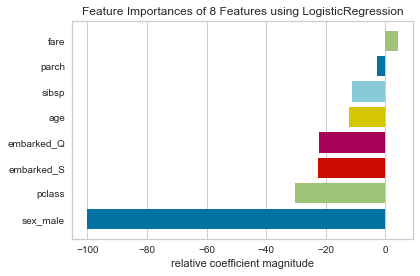

<AxesSubplot:title={'center':'Feature Importances of 8 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(lr)
fi_viz.fit(X, y)
fi_viz.poof()

In [8]:
# Naive Bayes

nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)
nb.predict(X.iloc[[0]])
nb.predict_proba(X.iloc[[0]])
nb.predict_log_proba(X.iloc[[0]])

array([[-0.04128748, -3.20776872]])

In [9]:
# SVC

svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)
svc.predict(X.iloc[[0]])
svc.predict_proba(X.iloc[[0]])
svc.predict_log_proba(X.iloc[[0]])

array([[-0.16538299, -1.88104347]])

In [10]:
# K Nearest Neighbor

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc.score(X_test, y_test)
knc.predict(X.iloc[[0]])
knc.predict_proba(X.iloc[[0]])

array([[0.8, 0.2]])

In [11]:
# Decision Tree

dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)
dt.predict(X.iloc[[0]])
dt.predict_proba(X.iloc[[0]])
dt.predict_log_proba(X.iloc[[0]])

array([[-0.12835003, -2.11648281]])

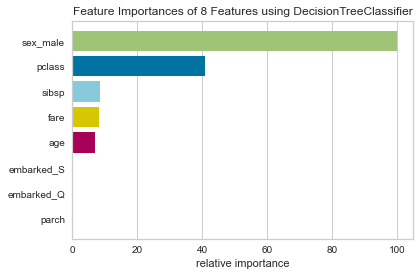

<AxesSubplot:title={'center':'Feature Importances of 8 Features using DecisionTreeClassifier'}, xlabel='relative importance'>

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(dt)
fi_viz.fit(X, y)
fi_viz.poof()

In [13]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rfpimp.importances(
    rf, X_test, y_test
).Importance

Feature
sex_male      0.193384
age           0.071247
pclass        0.035623
fare          0.017812
parch         0.012723
embarked_S    0.010178
sibsp         0.000000
embarked_Q   -0.010178
Name: Importance, dtype: float64

In [14]:
xgb_class = xgb.XGBClassifier(random_state=42)
xgb_class.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
)
xgb_class.score(X_test, y_test)
xgb_class.predict(X.iloc[[0]])
xgb_class.predict_proba(X.iloc[[0]])

C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.57936
[1]	validation_0-logloss:0.52320
[2]	validation_0-logloss:0.49346
[3]	validation_0-logloss:0.47456
[4]	validation_0-logloss:0.46561
[5]	validation_0-logloss:0.46175
[6]	validation_0-logloss:0.46105
[7]	validation_0-logloss:0.45906
[8]	validation_0-logloss:0.46439
[9]	validation_0-logloss:0.46452
[10]	validation_0-logloss:0.46231
[11]	validation_0-logloss:0.46156
[12]	validation_0-logloss:0.45924
[13]	validation_0-logloss:0.46608
[14]	validation_0-logloss:0.46252
[15]	validation_0-logloss:0.46300
[16]	validation_0-logloss:0.45862
[17]	validation_0-logloss:0.45949
[18]	validation_0-logloss:0.46089
[19]	validation_0-logloss:0.46385
[20]	validation_0-lo

array([[0.9089531 , 0.09104695]], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

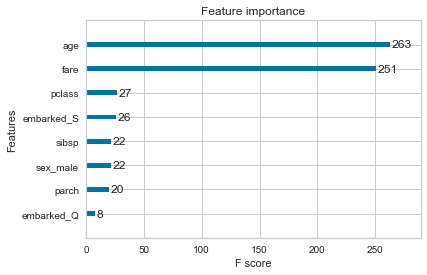

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgb_class, ax=ax)

In [16]:
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[sex_male<1] yes=1,no=2,missing=1
	1:[pclass<0.23096557] yes=3,no=4,missing=3
		3:leaf=0.508235335
		4:[fare<-0.203882411] yes=7,no=8,missing=7
			7:[fare<-0.500062585] yes=13,no=14,missing=13
				13:leaf=0.400000036
				14:[fare<-0.355997324] yes=21,no=22,missing=21
					21:[age<-0.0881969854] yes=27,no=28,missing=27
						27:leaf=-0.0315789506
						28:leaf=-0.347368419
					22:[embarked_S<1] yes=29,no=30,missing=29
						29:leaf=0.284210533
						30:leaf=0.0782608688
			8:[age<-0.456013232] yes=15,no=16,missing=15
				15:leaf=-0.461538494
				16:leaf=-0.163636371
	2:[age<-1.49289143] yes=5,no=6,missing=5
		5:[sibsp<1.35050142] yes=9,no=10,missing=9
			9:[age<-2.16597414] yes=17,no=18,missing=17
				17:leaf=0.0666666701
				18:leaf=0.450000018
			10:leaf=-0.388235331
		6:[pclass<-0.957598865] yes=11,no=12,missing=11
			11:[embarked_S<1] yes=19,no=20,missing=19
				19:[fare<0.838983417] yes=23,no=24,missing=23
					23:[age<-0.0686873421] yes=31,no=32,missing=31
						31:leaf=0.20000

In [17]:
cat_df = df.copy()
cat_df = cat_df.drop(
    [
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ],
    axis=1,
)
cat_df = cat_df.fillna(cat_df.median())
cat_df = cat_df.fillna(
    "missing"
)  # for objects
# cat_X, cat_y = jn.get_features_targets(
#     cat_df, target_columns="survived"
# )
X_train3, X_test3, y_train3, y_test3 = model_selection.train_test_split(
    cat_df.drop('survived', axis=1),
    cat_df['survived'],
    test_size=0.3,
    random_state=42,
)
cat_idxs = np.where(cat_df.drop('survived', axis=1).dtypes == object)[0]
cb = CatBoostClassifier(random_state=42)
cb.fit(
    X_train3,
    y_train3,
    cat_features=cat_idxs,
    plot=True,
)
cb.score(X_test3, y_test3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009923
0:	learn: 0.6871733	total: 162ms	remaining: 2m 42s
1:	learn: 0.6809450	total: 190ms	remaining: 1m 34s
2:	learn: 0.6751306	total: 208ms	remaining: 1m 9s
3:	learn: 0.6696186	total: 229ms	remaining: 57.1s
4:	learn: 0.6661256	total: 244ms	remaining: 48.6s
5:	learn: 0.6605950	total: 266ms	remaining: 44.1s
6:	learn: 0.6574164	total: 285ms	remaining: 40.5s
7:	learn: 0.6523702	total: 307ms	remaining: 38.1s
8:	learn: 0.6470302	total: 344ms	remaining: 37.9s
9:	learn: 0.6440684	total: 352ms	remaining: 34.8s
10:	learn: 0.6396224	total: 366ms	remaining: 32.9s
11:	learn: 0.6351698	total: 402ms	remaining: 33.1s
12:	learn: 0.6307152	total: 416ms	remaining: 31.6s
13:	learn: 0.6261520	total: 453ms	remaining: 31.9s
14:	learn: 0.6224333	total: 466ms	remaining: 30.6s
15:	learn: 0.6185786	total: 486ms	remaining: 29.9s
16:	learn: 0.6149004	total: 506ms	remaining: 29.3s
17:	learn: 0.6112778	total: 517ms	remaining: 28.2s
18:	learn: 0.6074382	total: 537ms	remaining: 27.7s
19:	learn

0.8015267175572519

In [18]:
for col, val in sorted(
    zip(
        X_test3.columns,
        cb.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

sex           37.714
pclass        16.354
fare          14.465
age           13.468
embarked       9.909


In [21]:
tc = TPOTClassifier(generations=2)
tc.fit(X_train, y_train)
print(tc.score(X_test, y_test))
tc.predict(X.iloc[[0]])
tc.predict_proba(X.iloc[[0]])

array([[0.88948791, 0.11051209]])

In [23]:
print(tc.score(X_test, y_test))

0.7989821882951654
